In [13]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from sklearn.metrics import r2_score  # R2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential

In [29]:
# 设置路径
input_path = 'C:\\Users\\iii\\Desktop\\LSTM+AQI\\数据和测算结果\\'
output_path = 'C:\\Users\\iii\\Desktop\\LSTM+AQI\\数据和测算结果\\'

In [32]:
# 读取数据
data = pd.read_excel(input_path+'aqi_eemd_out.xlsx', index_col='日期')

### 先以IMF1为例

In [33]:
data_IMF = data[['IMF2']]
data_IMF.head(2)

,IMF2
日期,
2014-01-01,-29.022702
2014-01-02,36.411221


(1,)
(1,)
计算初始全局最优
6/6 [==============================] - 7s 356ms/step - loss: 6574.8149 - val_loss: 970.2161
初始全局最优参数：[2.59000000e+02 1.42770708e-01 9.50000000e+01]
6/6 [==============================] - 7s 360ms/step - loss: 6574.1631 - val_loss: 970.2322
搜索步数：0
个体最优参数：[[2.59000000e+02 1.42770708e-01 9.50000000e+01]]
全局最优参数：[2.59000000e+02 1.42770708e-01 9.50000000e+01]
6/6 [==============================] - 7s 351ms/step - loss: 6573.8984 - val_loss: 970.1818
搜索步数：1
个体最优参数：[[2.59000000e+02 1.42770708e-01 9.50000000e+01]]
全局最优参数：[2.59000000e+02 1.42770708e-01 9.50000000e+01]
计算初始全局最优
6/6 [==============================] - 7s 362ms/step - loss: 6574.6372 - val_loss: 970.0694
初始全局最优参数：[2.59000000e+02 1.42770708e-01 9.50000000e+01]
6/6 [==============================] - 7s 383ms/step - loss: 6575.8540 - val_loss: 970.3442
搜索步数：0
个体最优参数：[[2.59000000e+02 1.42770708e-01 9.50000000e+01]]
全局最优参数：[2.59000000e+02 1.42770708e-01 9.50000000e+01]
6/6 [==============================] - 7s 352ms/s

D:\DataScience\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\DataScience\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\DataScience\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 36845 (\N{CJK UNIFIED IDEOGRAPH-8FED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\DataScience\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


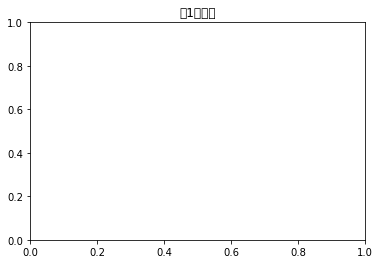

In [34]:
batch_size = 128
epochs = 2
# steps = 10

def process_data():
    dataset = data_IMF
    #columns = ['SP', 'High', 'Low', 'KP', 'QSP', 'ZDE', 'ZDF', 'CJL']
    columns = ['IMF2']
    '''
    for col in columns:
        scaler = MinMaxScaler()
        dataset[col] = scaler.fit_transform(dataset[col].values.reshape(-1, 1))
    '''
    X = dataset.drop(columns=['IMF2'], axis=1)
    y = dataset['IMF2']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, shuffle=False, random_state=666)

    return X_train, y_train, X_test, y_test


def create_dataset(X, y, seq_len=10):
    features = []
    targets = []  # 标签

    for i in range(0, len(X) - seq_len, 1):  # 此处的1表示步长，每隔一步滑一下
        data = X.iloc[i:i + seq_len]  # 序列数据；前闭后开
        label = y.iloc[i + seq_len]  # 标签数据
        # 保存到features和labels
        features.append(data)
        targets.append(label)

    return np.array(features), np.array(targets)


X_train, y_train, X_test, y_test = process_data()
train_dataset, train_labels = create_dataset(X_train, y_train, seq_len=10)
X_test, y_test = create_dataset(X_test, y_test, seq_len=10)

from tensorflow.keras import Sequential, layers

def build_model(neurons, dropout):
    model = Sequential([
        layers.LSTM(units=neurons, input_shape=train_dataset.shape[-2:], return_sequences=True),
        # units=256表示有256个神经元；return_sequences=True表示将结果传到下一步
        layers.Dropout(dropout),  # 表示删除一些神经元
        layers.LSTM(units=128, return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(units=64, return_sequences=True),
        layers.LSTM(units=16),
        layers.Dense(1)  # 因为只有一个特征值的输出
    ])
    return model


def training(X):
    neurons = int(X[0])
    dropout = round(X[1], 6)
    batch_size = int(X[2])
    model = build_model(neurons, dropout)
    model.compile(optimizer='adam',
                  loss='mse')
    model.fit(
        train_dataset,
        train_labels,
        batch_size=batch_size,
        epochs=1,
        validation_data=(X_test, y_test),
        verbose=1)
    model.save(
        'neurons' + str(int(X[0])) + '_dropout' + str(dropout) + '_batch_size' + str(batch_size) + '.h5')
    # 训练完成后可直接加载模型
    # model_lstm = load_model('LSTM_bus_' + str(X[0]) + '_' + str(X[1]) + '_' + str(X[2]) + '_' + '.h5')
    pred = model.predict(X_test)
    le = len(pred)
    y_t = y_test.reshape(-1, 1)
    return pred, le, y_t


def function(ps, test, le):
    ss = sum(((abs(test - ps)) / test) / le)
    return ss


# (1) PSO Parameters
MAX_EPISODES = 2
MAX_EP_STEPS = 2
c1 = 1
c2 = 1
w = 0.5
pN = 1  # 粒子数量

# (2) LSTM Parameters
dim = 3  # 搜索维度
X = np.zeros((pN, dim))  # 所有粒子的位置和速度
V = np.zeros((pN, dim))
pbest = np.zeros((pN, dim))  # 个体经历的最佳位置和全局最佳位置
gbest = np.zeros(dim)
p_fit = np.zeros(pN)  # 每个个体的历史最佳适应值
print(p_fit.shape)
print(p_fit.shape)
t1 = time.time()

'''
神经网络第一层神经元个数： 256-259
dropout比率： 0.03-0.19
batch_size： 64-128
'''
UP = [259, 0.19, 128]
DOWN = [256, 0.03, 64]

# (4) 开始搜索
for i_episode in range(MAX_EPISODES):
    """初始化s"""
    random.seed(8)
    fit = -1e5  # 全局最佳适应值
    # 初始粒子适应度计算
    print("计算初始全局最优")
    for i in range(pN):
        for j in range(dim):
            V[i][j] = random.uniform(0, 1)
            if j == 1:
                X[i][j] = random.uniform(DOWN[j], UP[j])
            else:
                X[i][j] = round(random.randint(DOWN[j], UP[j]), 0)
        pbest[i] = X[i]
        le, pred, y_t = training(X[i])
        NN = 1
        tmp = function(pred, y_t, le)
        p_fit[i] = tmp
        if tmp > fit:
            fit = tmp
            gbest = X[i]
    print("初始全局最优参数：{:}".format(gbest))

    fitness = []  # 适应度函数
    for j in range(MAX_EP_STEPS):
        fit2 = []
        plt.title("第{}次迭代".format(i_episode))
        for i in range(pN):
            le, pred, y_t = training(X[i])
            temp = function(pred, y_t, le)
            fit2.append(temp / 1000)
            if temp > p_fit[i]:  # 更新个体最优
                p_fit[i] = temp
                pbest[i] = X[i]
                if p_fit[i] > fit:  # 更新全局最优
                    gbest = X[i]
                    fit = p_fit[i]
        print("搜索步数：{:}".format(j))
        print("个体最优参数：{:}".format(pbest))
        print("全局最优参数：{:}".format(gbest))
        # [30.          0.14277071 95.        ]
        for i in range(pN):
            V[i] = w * V[i] + c1 * random.uniform(0, 1) * (pbest[i] - X[i]) + c2 * random.uniform(0, 1) * (gbest - X[i])
            ww = 1
            for k in range(dim):
                if DOWN[k] < X[i][k] + V[i][k] < UP[k]:
                    continue
                else:
                    ww = 0
            X[i] = X[i] + V[i] * ww
        fitness.append(fit)

print('Running time: ', time.time() - t1)

# 训练模型  使用PSO找到的最好的神经元个数
neurons = int(gbest[0])
dropout = gbest[1]
batch_size = int(gbest[2])
model = build_model(neurons, dropout)
model.compile(optimizer='adam',
              loss='mse')
model.summary()
history = model.fit(train_dataset, train_labels, epochs=epochs, batch_size=batch_size, verbose=2)

# 模型预测数据
test_preds = model.predict(X_test)
test_preds = test_preds[:, 0] # 获取数组中的第1列值


# 计算r2值
score = r2_score(y_test, test_preds)
print("r^2 值为： ", score)
'''
# 绘制 预测与真值结果
plt.figure(figsize=(16,8))
plt.plot(y_test[:1149], label="True value")
plt.plot(test_preds[:1149], label="Pred value")#预测值
plt.legend(loc='best')
plt.show()
# 显示训练结果

plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='train loss')
plt.legend(loc='best')
plt.show()
'''
from sklearn import metrics
'''
#MSE
print(metrics.mean_squared_error(y_test,test_preds))
#RMSE
print(np.sqrt(metrics.mean_squared_error(y_test,test_preds)))
'''
#MAE
print(metrics.mean_absolute_error(y_test,test_preds))
print(y_test)
print(test_preds)

In [35]:
print(y_test)
print(test_preds)

[-5.40821838e+00  2.11242879e+00  1.11308354e+01  2.04098532e+01
  2.87123338e+01  3.48011290e+01  3.74390905e+01  3.56695401e+01
  2.96576810e+01  1.98491865e+01  6.68972995e+00 -9.21633369e+00
 -2.62925963e+01 -4.14546637e+01 -5.17258596e+01 -5.59096861e+01
 -5.32362605e+01 -4.34157356e+01 -2.83548378e+01 -1.05140444e+01
  7.64616729e+00  2.36653201e+01  3.54412686e+01  4.23051948e+01
  4.39550704e+01  4.04471045e+01  3.31435867e+01  2.37312122e+01
  1.37690071e+01  4.30532031e+00 -3.83886318e+00 -1.02413364e+01
 -1.45795868e+01 -1.65311020e+01 -1.59610333e+01 -1.34898545e+01
 -9.94437293e+00 -6.07474717e+00 -2.30587003e+00  1.01868210e+00
  3.55533281e+00  4.96050569e+00  4.98776857e+00 -2.89180254e+01
 -2.97677296e+01 -2.91615635e+01 -2.69994069e+01 -2.34479293e+01
 -1.87402917e+01 -1.31096546e+01 -6.78917890e+00 -1.20252797e-02
  6.98864549e+00  1.39696407e+01  2.06418109e+01  2.66826586e+01
  3.17638573e+01  3.55570803e+01  3.77340011e+01  3.79662932e+01
  3.60293669e+01  3.21135